In [10]:
import numpy as np
import matplotlib.pyplot as plt

from poles_roots._utils import compute_incenter, convert_cart_to_complex
from poles_roots.integration import argument_principle_from_points

In [2]:
tri_points = np.array([[0, 0], [5, 0], [0, 5]])
center = compute_incenter(*tri_points)

x_points = np.logspace(0, np.log2(center[0]+1), base=2, num=20) - 1
locations_cart = np.stack([x_points, center[1]*np.ones_like(x_points)]).T

# Convergence as pole/zero approaches contour

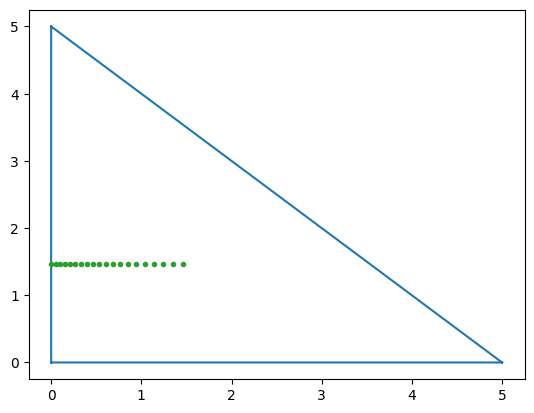

In [3]:
fig, ax = plt.subplots()
ax.triplot(*tri_points.T)
ax.plot(*locations_cart.T, '.')

In [4]:
locations = convert_cart_to_complex(locations_cart)
points = convert_cart_to_complex(tri_points)
errors_quad_pole = []
errors_fixed_pole = []
errors_quad_zero = []
errors_fixed_zero = []
for location in locations:
    def f_pole(z):
        return 1/(z-location)
    
    def f_pole_prime(z):
        return -1/(z-location)**2
    
    def f_zero(z):
        return z - location
    
    def f_zero_prime(z):
        return 1
    
    res = argument_principle_from_points(f_pole, f_pole_prime, points=points)[0]
    errors_quad_pole.append(np.abs(-1 - res))
    res = argument_principle_from_points(f_pole, f_pole_prime, points=points, method="fixed", quad_kwargs={"n":50})[0]
    errors_fixed_pole.append(np.abs(-1 - res))
    
    res = argument_principle_from_points(f_zero, f_zero_prime, points=points)[0]
    errors_quad_zero.append(np.abs(1 - res))
    res = argument_principle_from_points(f_zero, f_zero_prime, points=points, method="fixed", quad_kwargs={"n":50})[0]
    errors_fixed_zero.append(np.abs(1 - res))
    
    

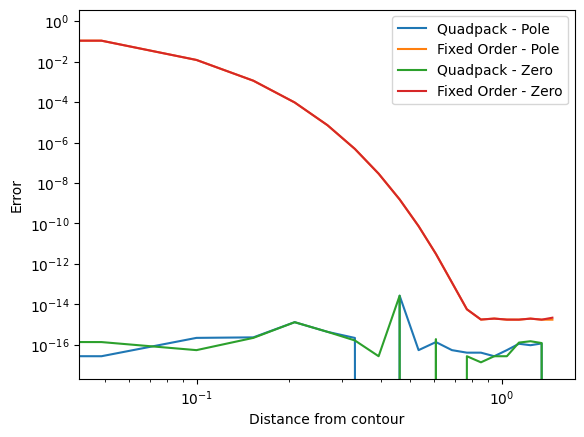

In [5]:
fig, ax = plt.subplots()
ax.loglog(locations.real, errors_quad_pole, label="Quadpack - Pole")
ax.loglog(locations.real, errors_fixed_pole, label="Fixed Order - Pole")
ax.loglog(locations.real, errors_quad_zero, label="Quadpack - Zero")
ax.loglog(locations.real, errors_fixed_zero, label="Fixed Order - Zero")
ax.set_ylabel("Error")
ax.set_xlabel("Distance from contour")
ax.legend()

# Convergence as N increases

In [6]:
N = 10

Ns = []
guass_error = []
trap_error = []

def f(z):
    return z - center[0] - center[1]*1j

for i in range(5):
    Ns.append(N)
    
    res = argument_principle_from_points(f, lambda z: 1, points=points, method="fixed", quad_kwargs={"n":N})[0]
    guass_error.append(np.abs(1 - res))
    res = argument_principle_from_points(f, lambda z: 1, points=points, method="trapezium", quad_kwargs={"num":N})[0]
    trap_error.append(np.abs(1 - res))
    
    N *= 2

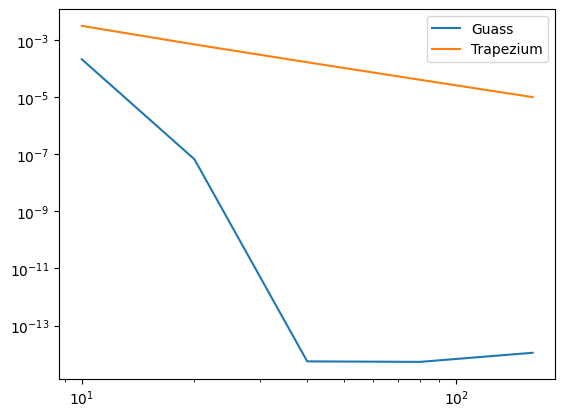

In [10]:
fig, ax = plt.subplots()
ax.loglog(Ns, guass_error, label="Guass")
ax.loglog(Ns, trap_error, label="Trapezium")
ax.legend()

In [54]:
from mpmath import mp
mp.dps = 100

a = mp.mpc(real=0, imag="1e-2")

ref = mp.quad(lambda z: 1/(z-a), [-1, 1])
print(ref)

(0.0 + 3.121593328234448251419886603317179086117407736999516645983402707923138566823871151227355387541036443j)


In [55]:
def kernel(z, n):
    return mp.quad(lambda t: mp.legendre(n, t)/(z-t), [-1, 1])/mp.legendre(n, z)

In [56]:
import scipy
import scipy.integrate

err = []
theoretical = []
error_in_error = []
ns = np.logspace(1, 3, dtype=int, num=10)

for n in ns:
    quad_error = mp.fabs(scipy.integrate.fixed_quad(lambda z: 1/(z-complex(a)), -1, 1, n=n)[0] - ref)
    predicted = mp.fabs(kernel(a, n))
    err.append(quad_error)
    theoretical.append(predicted)
    error_in_error.append(mp.fabs(quad_error - predicted))

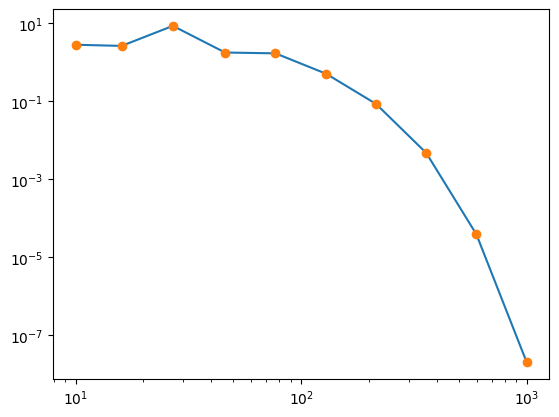

In [57]:
plt.loglog(ns, err)
plt.loglog(ns, theoretical, 'o')

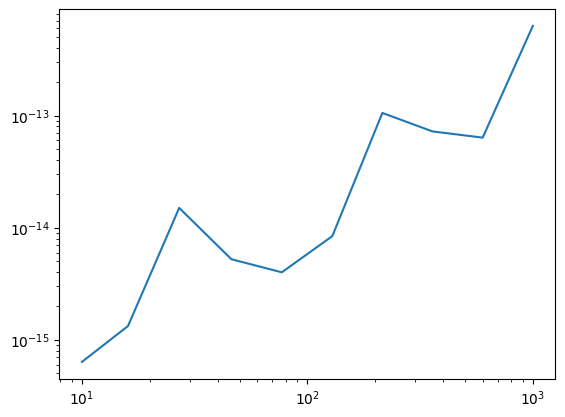

In [58]:
plt.loglog(ns, error_in_error)